In [1]:
import json
import os
import argparse

import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from pathlib import Path
from torch.utils.data import DataLoader, Subset
import sys
sys.path.append('../lib/exlib/src')
# sys.path.append('../lib/pytorch-grad-cam')
from exlib.modules.sop import SOPImageCls, SOPConfig, get_chained_attr

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 42
if SEED != -1:
    # Torch RNG
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Python RNG
    np.random.seed(SEED)
    random.seed(SEED)

In [3]:
# model paths
backbone_model_name = '../pt_models/vit-base-patch16-224-imagenet10cls'
backbone_processor_name = 'google/vit-base-patch16-224'
# sop_config_path = 'configs/imagenet_m.json'

# data paths
TRAIN_DATA_DIR = '../data/imagenet_m/train'
VAL_DATA_DIR = '../data/imagenet_m/val'

# training args
batch_size = 1
lr = 0.000005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

# experiment args
exp_dir = '../exps/imagenet_m_2h/best'

In [4]:
backbone_model = AutoModelForImageClassification.from_pretrained(backbone_model_name)
processor = AutoImageProcessor.from_pretrained(backbone_processor_name)
backbone_config = AutoConfig.from_pretrained(backbone_model_name)

config = SOPConfig()
config.update_from_json(os.path.join(exp_dir, 'config.json'))

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def transform(image):
    # Preprocess the image using the ViTImageProcessor
    image = image.convert("RGB")
    inputs = processor(image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)

# Load the dataset
train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
val_dataset = ImageFolder(root=VAL_DATA_DIR, transform=transform)

# Use subset for testing purpose
# num_data = 100
# train_dataset = Subset(train_dataset, range(num_data))
# val_dataset = Subset(val_dataset, range(num_data))

# Create a DataLoader to batch and shuffle the data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return WrappedBackboneOutput(outputs.logits, outputs.hidden_states[-1][:,0])

In [7]:
class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [8]:
wrapped_backbone_model = WrappedBackboneModel(backbone_model)
wrapped_backbone_model = wrapped_backbone_model.to(device)
class_weights = get_chained_attr(wrapped_backbone_model, config.finetune_layers[0]).weight #.clone().to(device)

In [9]:
model = SOPImageCls(config, wrapped_backbone_model, class_weights=class_weights, projection_layer=None)
state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth'))
model.load_state_dict(state_dict['model'])
model = model.to(device)
model.eval();

deep copy class weights


In [10]:
original_model = WrappedModel(backbone_model)
original_model = original_model.to(device)

In [11]:
batch = next(iter(val_dataloader))
inputs, labels = batch
inputs, labels = inputs.to(device), labels.to(device)

## Archipelago

In [13]:
from exlib.explainers.archipelago import ArchipelagoImageCls

explainer = ArchipelagoImageCls(original_model)
explainer = explainer.to(device)
arc_expln = explainer(inputs, labels)

torch.Size([1, 1, 224, 224])
torch.Size([1, 224, 224])


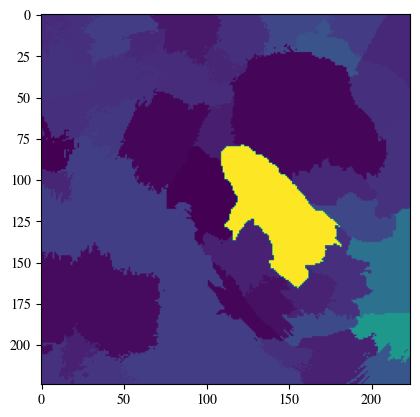

In [16]:
import matplotlib.pyplot as plt

plt.imshow(arc_expln.attributions[0][0].cpu().numpy())

In [20]:
len(arc_expln.explainer_output['masks']), arc_expln.explainer_output['masks'][0].shape

(1, torch.Size([42, 224, 224]))

In [21]:
len(arc_expln.explainer_output['mask_weights']), arc_expln.explainer_output['mask_weights'][0].shape

(1, torch.Size([42]))

In [24]:
arc_expln.explainer_output['mask_weights'][0]

tensor([ 9.2433,  4.5881,  2.9611,  1.9041,  1.7883,  1.4909,  1.4238,  1.3721,
         1.0981,  1.0661,  1.0403,  1.0326,  0.8619,  0.7711,  0.7031,  0.6753,
         0.6621,  0.6468,  0.5959,  0.5814,  0.5782,  0.5778,  0.5180,  0.4279,
         0.4019,  0.3995,  0.3987,  0.3157,  0.3079,  0.1875,  0.1569,  0.1467,
         0.1436,  0.0616, -0.0814, -0.3088, -0.4586, -0.5909, -0.6269, -0.6304,
        -0.7434, -0.7597], device='cuda:0')

In [27]:
from tqdm.auto import tqdm

grouped_attrs = []
for i in tqdm(range(10)):
    arc_expln = explainer(inputs, torch.tensor([i]))
    grouped_attrs.append(arc_expln.explainer_output['mask_weights'][0])

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
grouped_attrs_aggr = torch.tensor([ga.sum() for ga in grouped_attrs])
grouped_attrs_aggr

tensor([34.9282, 36.1642, 41.2544, 45.9257, 56.2730, 26.2573, 69.8167, 26.1337,
        41.6529, 29.9351])

In [29]:
torch.argmax(grouped_attrs_aggr)

tensor(6)

In [30]:
labels

tensor([0], device='cuda:0')

## Lime

In [13]:
from exlib.explainers.lime import LimeImageCls
from exlib.explainers.common import patch_segmenter

eik = {
    "segmentation_fn": patch_segmenter,
    "top_labels": 1000, 
    "hide_color": 0, 
    "num_samples": 1000
}
gimk = {
    "positive_only": False
}
lime_explainer = LimeImageCls(original_model, 
                      explain_instance_kwargs=eik, 
                      get_image_and_mask_kwargs=gimk)

lime_expln = lime_explainer(inputs, labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

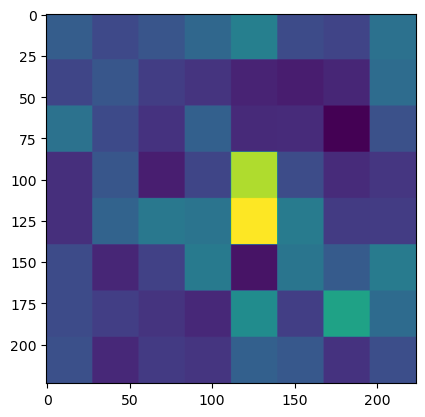

In [18]:
import matplotlib.pyplot as plt

plt.imshow(lime_expln.attributions[0][0].cpu().numpy())

In [20]:
lime_expln.explainer_output[0].segments.shape

(224, 224)

In [26]:
grouped_attrs_lime = []
for i in tqdm(range(10)):
    grouped_attrs_lime.append([v for k, v in lime_expln.explainer_output[0].local_exp[i]])

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
grouped_attrs_lime_aggr = torch.tensor([sum(ga) for ga in grouped_attrs_lime])
grouped_attrs_lime_aggr

tensor([10.1181,  3.6614,  4.1204,  5.9402,  5.7994,  3.1241,  2.3985, -1.3396,
        -3.1976, -2.7439], dtype=torch.float64)

In [30]:
torch.argmax(grouped_attrs_lime_aggr)

tensor(0)

## SHAP

In [12]:
from exlib.explainers import ShapImageCls

shap_explainer = ShapImageCls(original_model).to(device)

shap_expln = shap_explainer(inputs, labels)

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


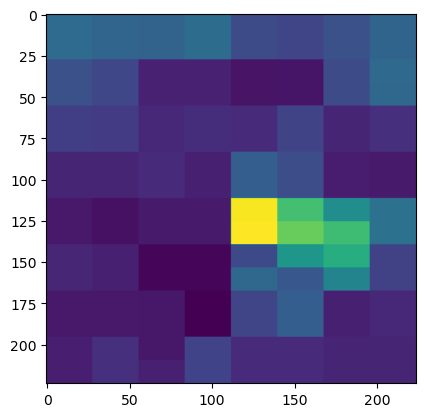

In [13]:
import matplotlib.pyplot as plt

plt.imshow(shap_expln.attributions[0][0].cpu().numpy())

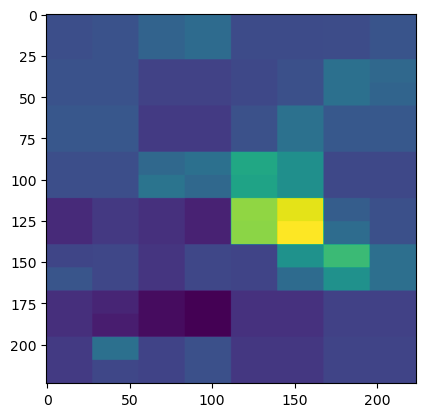

In [31]:
shap_expln = shap_explainer(inputs, torch.tensor([1]))
plt.imshow(shap_expln.attributions[0][0].cpu().numpy())

In [37]:
grouped_attrs_shap = []
for i in tqdm(range(10)):
    shap_expln = shap_explainer(inputs, torch.tensor([i]))
    grouped_attrs_shap.append(shap_expln.attributions.view(-1))
grouped_attrs_shap_aggr = torch.stack(grouped_attrs_shap).sum(-1)
grouped_attrs_shap_aggr

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([12.4653,  5.4695,  4.2645,  5.7603,  4.9919,  2.2466,  6.2427,  1.2154,
         1.2253,  0.7736], dtype=torch.float64)

In [38]:
torch.argmax(grouped_attrs_shap_aggr)

tensor(0)

## RISE

In [12]:
from exlib.explainers import RiseImageCls

rise_explainer = RiseImageCls(original_model).to(device)

rise_expln = rise_explainer(inputs, labels)

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


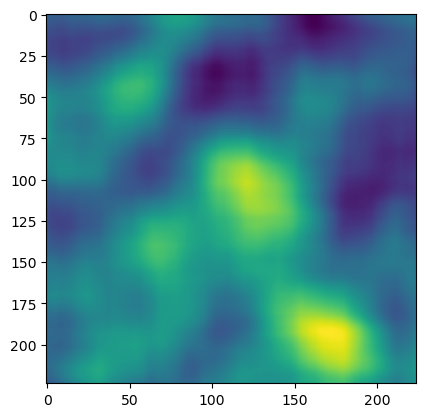

In [13]:
import matplotlib.pyplot as plt

plt.imshow(rise_expln.attributions[0][0].cpu().numpy())

In [14]:
rise_expln.explainer_output.shape

torch.Size([1, 10, 224, 224])

In [17]:
grouped_attrs_rise_aggr = rise_expln.explainer_output[0].sum(-1).sum(-1)
grouped_attrs_rise_aggr, torch.argmax(grouped_attrs_rise_aggr)

(tensor([5.3816e+08, 2.5299e+08, 1.7383e+08, 2.1951e+08, 2.4043e+08, 1.9186e+08,
         2.7809e+08, 2.8644e+07, 1.6272e+07, 4.9189e+06], device='cuda:0'),
 tensor(0, device='cuda:0'))

## IntGrad

In [18]:
from exlib.explainers import IntGradImageCls

intgrad_explainer = IntGradImageCls(original_model).to(device)

intgrad_expln = intgrad_explainer(inputs, labels)

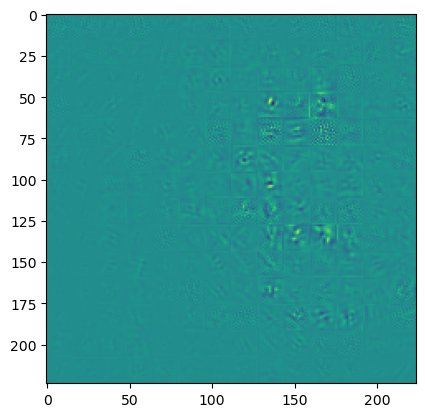

In [24]:
import matplotlib.pyplot as plt

plt.imshow(intgrad_expln.attributions[0].mean(0).cpu().numpy())

In [26]:
grouped_attrs_intgrad = []
for i in tqdm(range(10)):
    intgrad_expln = intgrad_explainer(inputs, torch.tensor([i]))
    grouped_attrs_intgrad.append(intgrad_expln.attributions.sum(1).view(-1))
grouped_attrs_intgrad_aggr = torch.stack(grouped_attrs_intgrad).sum(-1)
grouped_attrs_intgrad_aggr, torch.argmax(grouped_attrs_intgrad_aggr)

  0%|          | 0/10 [00:00<?, ?it/s]

(tensor([-3.7287e+00, -2.9831e-01,  2.2829e-01,  2.0972e+00,  1.0890e+00,
          4.6852e-01,  3.5330e-01, -4.2825e-01, -6.4699e-01,  3.5429e-04],
        device='cuda:0'),
 tensor(3, device='cuda:0'))

## GradCAM

In [12]:
from exlib.explainers import GradCAMImageCls

gradcam_explainer = GradCAMImageCls(original_model, [original_model.model.vit.encoder.layer[-1].layernorm_before]).to(device)

gradcam_expln = gradcam_explainer(inputs, labels)

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


In [13]:
gradcam_expln.attributions.shape

torch.Size([1, 1, 224, 224])

In [14]:
grouped_attrs_gradcam = []
for i in tqdm(range(10)):
    gradcam_expln = gradcam_explainer(inputs, torch.tensor([i]))
    grouped_attrs_gradcam.append(gradcam_expln.attributions.mean(1).view(-1))
grouped_attrs_gradcam_aggr = torch.stack(grouped_attrs_gradcam).sum(-1)
grouped_attrs_gradcam_aggr, torch.argmax(grouped_attrs_gradcam_aggr)

  0%|          | 0/10 [00:00<?, ?it/s]

(tensor([9275.5342, 8105.1675, 9275.5342, 8105.1689, 8105.1685, 8105.1646,
         8105.1709, 9275.5273, 9275.5244, 8104.9180]),
 tensor(0))

## FRESH

In [ ]:
with torch.no_grad():
    expln = model(inputs, return_tuple=True)

In [ ]:
expln.attributions.shape

In [ ]:
denormed_img = (inputs[0:1] + 1) / 2

## Aggregate Prediction Consistency

In [17]:
expln.masks.shape, expln.mask_weights.shape, expln.logits.shape, expln.logits_all.shape, expln.attributions_all.shape, expln.group_attributions.shape

(torch.Size([1, 392, 224, 224]),
 torch.Size([1, 392, 10]),
 torch.Size([1, 10]),
 torch.Size([1, 392, 10]),
 torch.Size([1, 10, 224, 224]),
 torch.Size([1, 392, 10]))

In [15]:
expln.group_attributions.sum(dim=-2) - expln.logits

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -9.5367e-07, -9.5367e-07,
          0.0000e+00,  0.0000e+00,  2.9802e-08,  3.7253e-09, -7.4506e-09]],
       device='cuda:0')

In [22]:
group_attributions.sum(dim=-2)

tensor([[11.8008,  5.9778,  8.9909,  9.7012,  9.2917,  4.5402,  6.5247,  0.3107,
         -0.0615,  0.0682]], device='cuda:0')

In [23]:
expln.logits

tensor([[11.8008,  5.9778,  8.9909,  9.7012,  9.2917,  4.5402,  6.5247,  0.3107,
         -0.0615,  0.0682]], device='cuda:0')

In [30]:
attrs = (expln.masks.bool().float().unsqueeze(2) * expln.mask_weights.unsqueeze(-1).unsqueeze(-1)).sum(1)
attrs.shape

torch.Size([1, 10, 224, 224])

In [34]:
attrs[0][labels].cpu().numpy()[0]

array([[0.96653795, 0.96653795, 0.96653795, ..., 0.9840308 , 0.9840308 ,
        0.9840308 ],
       [0.96653795, 0.96653795, 0.96653795, ..., 0.9840308 , 0.9840308 ,
        0.9840308 ],
       [0.96653795, 0.96653795, 0.96653795, ..., 0.9840308 , 0.9840308 ,
        0.9840308 ],
       ...,
       [0.7248243 , 0.7248243 , 0.7248243 , ..., 0.93425035, 0.93425035,
        0.93425035],
       [0.7248243 , 0.7248243 , 0.7248243 , ..., 0.93425035, 0.93425035,
        0.93425035],
       [0.7248243 , 0.7248243 , 0.7248243 , ..., 0.93425035, 0.93425035,
        0.93425035]], dtype=float32)

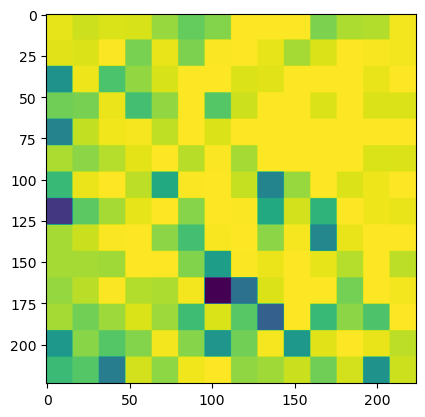

In [33]:
import matplotlib.pyplot as plt
plt.imshow(attrs[0][labels].cpu().numpy()[0])

In [35]:
attrs2 = (expln.masks.bool().float().unsqueeze(2) * expln.mask_weights.unsqueeze(-1).unsqueeze(-1) * expln.logits_all.unsqueeze(-1).unsqueeze(-1)).sum(1)
attrs2.shape

torch.Size([1, 10, 224, 224])

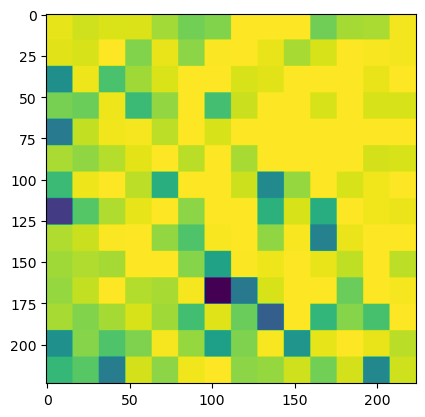

In [36]:
import matplotlib.pyplot as plt
plt.imshow(attrs2[0][labels].cpu().numpy()[0])

## Insertion Deletion

In [13]:
from exlib.evaluators.ins_del import InsertionCls, DeletionCls

 99%|█████████▉| 223/225 [08:37<00:04,  2.32s/it]


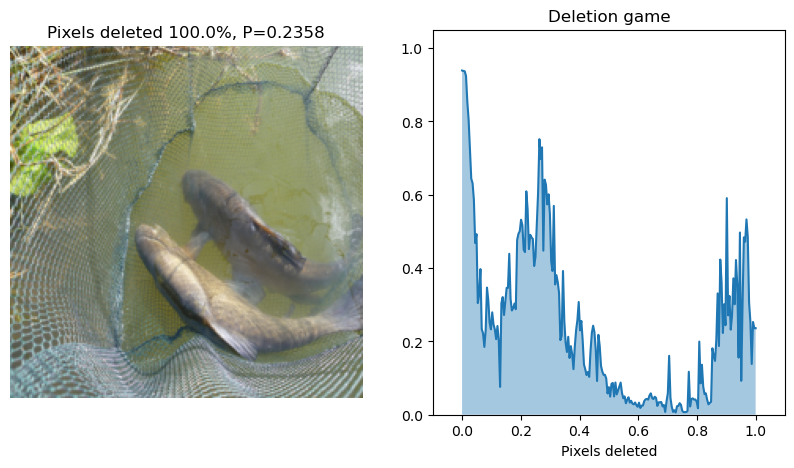

tensor([0.2419], device='cuda:0')


In [14]:
del_evaluator = DeletionCls(model)
with torch.no_grad():
    del_eval_output = del_evaluator(inputs, expln.attributions, return_dict=True)
del_scores = del_eval_output['scores']
del_evaluator.plot(denormed_img[0], del_scores[0])
print(del_eval_output['auc_score'])

 99%|█████████▉| 223/225 [08:56<00:04,  2.40s/it]


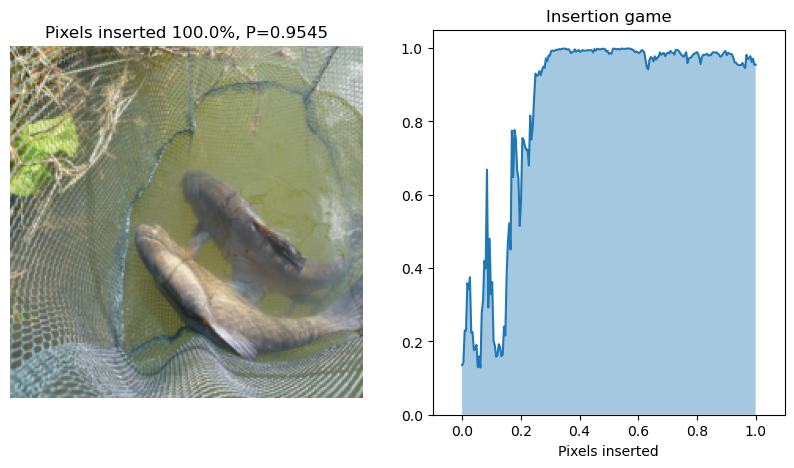

In [15]:
ins_evaluator = InsertionCls(model)
with torch.no_grad():
    ins_eval_output = ins_evaluator(inputs, expln.attributions, return_dict=True)
ins_evaluator.plot(denormed_img[0], ins_eval_output['scores'][0])

In [16]:
ins_eval_output['auc_score']

tensor([0.8429], device='cuda:0')

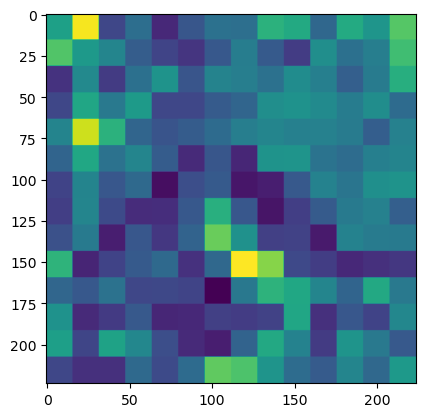

In [18]:
import matplotlib.pyplot as plt
plt.imshow(expln.attributions[0][0].cpu().numpy())

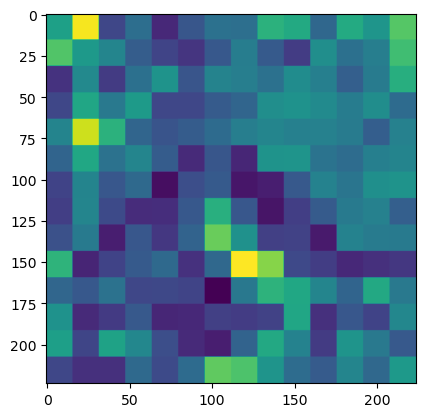

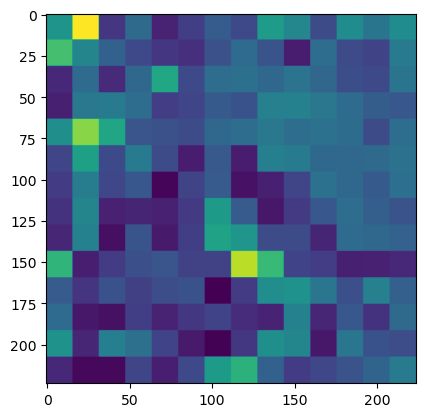

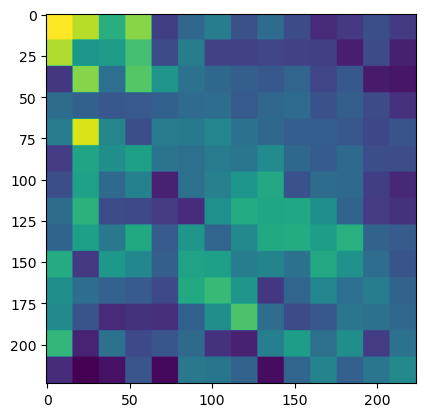

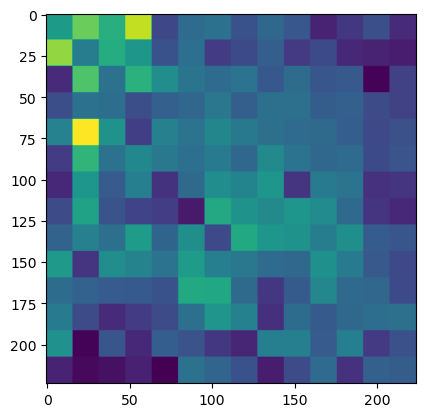

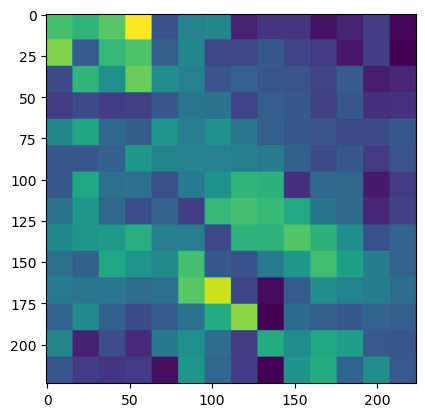

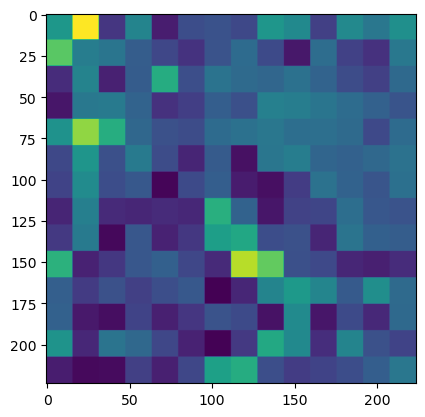

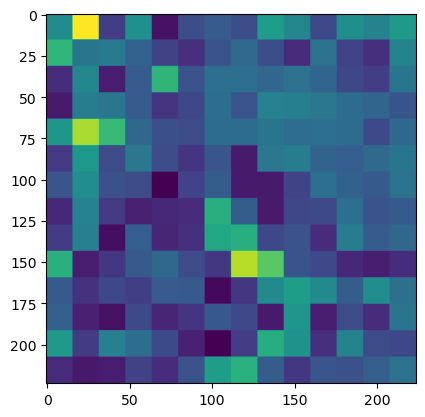

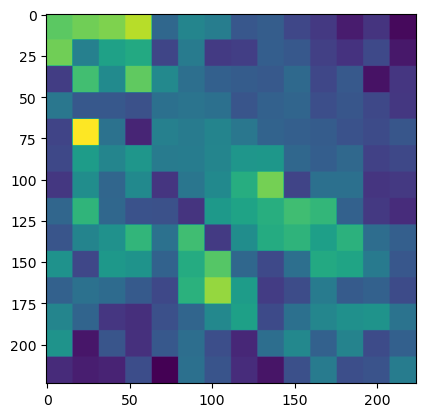

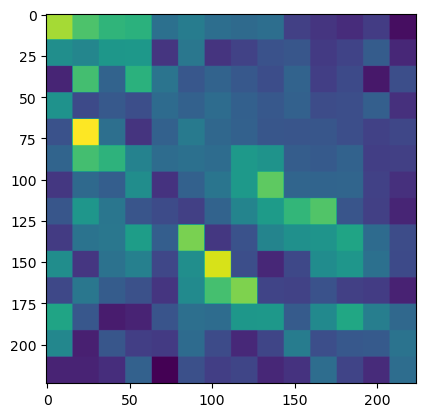

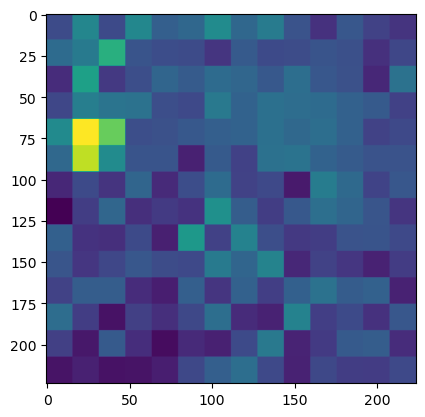

In [19]:
for i in range(expln.attributions_all.shape[1]):
    plt.figure()
    plt.imshow(expln.attributions_all[0][i].cpu().numpy())
    plt.show()

In [21]:
from exlib.evaluators.ins_del import GroupedInsertionCls, GroupedDeletionCls

In [22]:
gdel_evaluator = GroupedDeletionCls(model)
with torch.no_grad():
    gdel_score = gdel_evaluator(inputs, expln.attributions, expln.flat_masks)
print(gdel_score)

tensor([0.3955], device='cuda:0')


In [23]:
with torch.no_grad():
    gdel_eval_output = gdel_evaluator(inputs, expln.attributions[0], expln.flat_masks, return_dict=True)

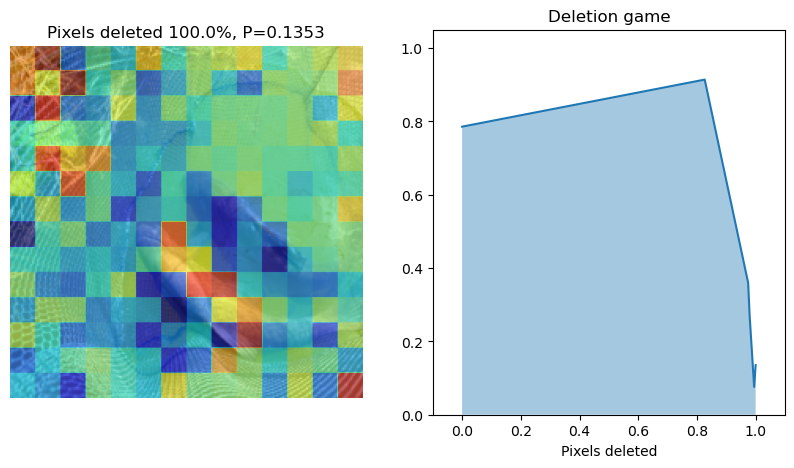

In [24]:
gdel_evaluator.plot(denormed_img[0], expln.attributions[0], gdel_eval_output['scores'][0], gdel_eval_output['step_sizes'][0])

In [17]:
gins_evaluator = GroupedInsertionCls(model)
with torch.no_grad():
    gins_score = gins_evaluator(inputs, expln.attributions, expln.flat_masks)
print(gins_score)

tensor([0.1230], device='cuda:0')


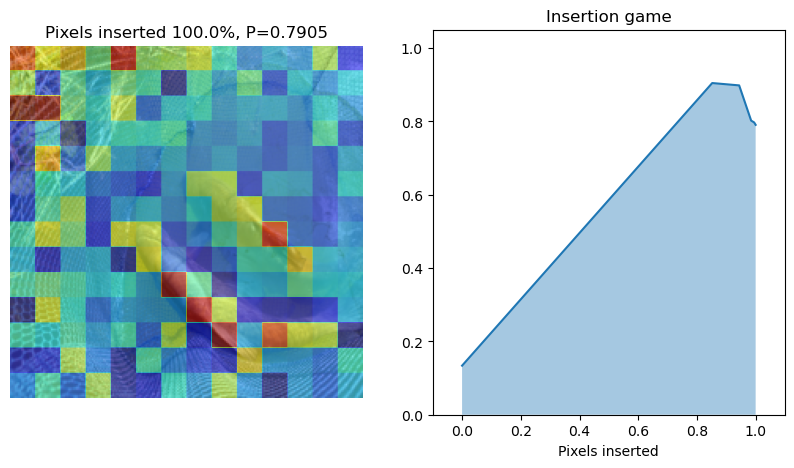

In [19]:
with torch.no_grad():
    gins_eval_output = gins_evaluator(inputs, expln.attributions, expln.flat_masks, return_dict=True)
gins_evaluator.plot(denormed_img[0], expln.attributions[0], gins_eval_output['scores'][0], gins_eval_output['step_sizes'][0])

In [20]:
gins_eval_output['scores']

[tensor([0.1338, 0.9046, 0.8982, 0.8021, 0.7971, 0.7905], device='cuda:0')]

## Baselines

### Archipelago

In [10]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import pickle

sys.path.append("../lib/archipelago/src")
from explainer import Archipelago
from application_utils.image_utils import *
from application_utils.utils_torch import ModelWrapperTorch

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [11]:
explanation_outline_thickness = 1

In [21]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [22]:
wrapped_backbone_model_raw = WrappedBackboneModelRaw(backbone_model)
wrapped_backbone_model_raw = wrapped_backbone_model_raw.to(device)
model_wrapper = ModelWrapperTorch(wrapped_backbone_model_raw, device)

image (224, 224, 3) label tensor(0, device='cuda:0')
classification: tench, Tinca tinca


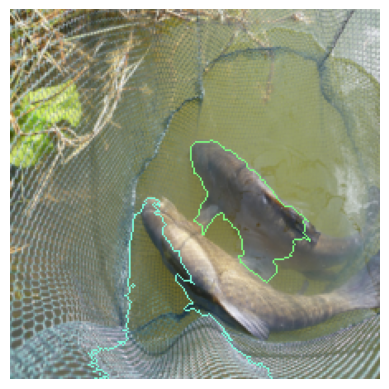

In [31]:
top_k = 5

# results = []
# for index in tqdm(indexes[:12+len(skip_imgs)]):    
# if index in skip_imgs: continue

# image_path = test_data[index]
# img_filename = image_path.split("/")[-1]
# image, labels = get_image_and_labels(image_path, device)

image = inputs[0].cpu().permute(1,2,0).numpy()
label = labels[0]
print('image', image.shape, 'label', label)

predictions = model_wrapper(np.expand_dims(image,0))
class_idx = predictions[0].argsort()[::-1][0]
print("classification:",backbone_config.id2label[class_idx])

baseline = np.zeros_like(image)
segments = quickshift(image, kernel_size=3, max_dist=300, ratio=0.2)

xf = ImageXformer(image, baseline, segments)
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)
explanation = apgo.explain(top_k=top_k)
exp, num_pos_interactions = overlay_explanation(explanation, image, segments, outline_thickness = explanation_outline_thickness)


plt.imshow(exp/2+0.5)
plt.axis("off")
plt.show()
    
    # results.append( {"image":exp, "prediction": labels[class_idx]} )
    
#     with open('results/exp_figs_4-21_k5_nohuman_thin.pickle', 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [32]:
explanation

{(0,): 0.42529047,
 (1,): 1.3719839,
 (2,): 1.0474758,
 (3,): -0.085602075,
 (4,): 0.58869743,
 (5,): 1.0348862,
 (6,): 0.40848237,
 (7,): 0.38664788,
 (8,): 1.7787969,
 (9,): 0.29978138,
 (10,): 0.5662061,
 (11,): 0.51545054,
 (12,): 0.7138524,
 (13,): 0.8627353,
 (14,): 0.5923417,
 (15,): -0.62160134,
 (16,): 0.07945675,
 (17,): 0.68777966,
 (18,): -0.5787919,
 (19,): -0.773232,
 (20,): 0.3929776,
 (21,): 0.3048277,
 (22,): -0.7482835,
 (23, 27): 9.251493,
 (24,): 1.4461168,
 (25,): 0.17124562,
 (26,): 1.110541,
 (28, 39, 40, 43, 46): 1.0905472,
 (29,): 0.5786019,
 (30,): 2.946011,
 (31,): -0.43382567,
 (32,): 0.18923682,
 (33,): -0.28266913,
 (34,): -0.6338183,
 (35,): 4.5963902,
 (36,): 1.4934913,
 (37,): 0.16700691,
 (38,): 0.13798222,
 (41,): 0.64322615,
 (42,): 1.9124115,
 (44,): 0.6619823,
 (45,): 0.79127645}

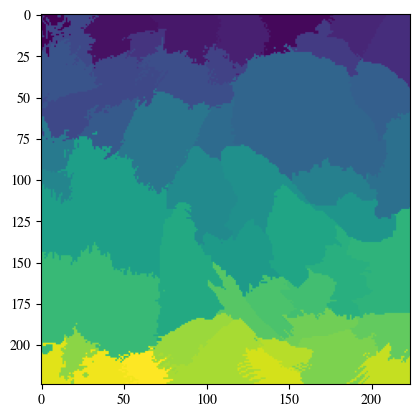

In [35]:
plt.imshow(segments)

In [36]:
segments.shape

(224, 224)

torch.Size([1, 224, 224])


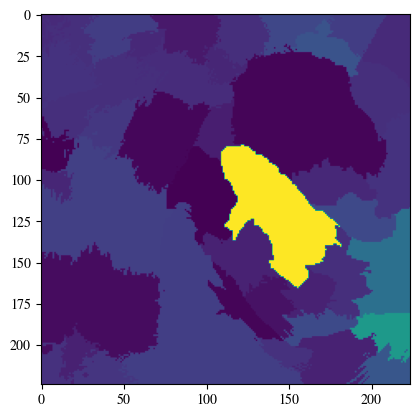

In [89]:
expln_scores = np.zeros_like(segments, dtype=float)
expln_flat_masks = np.zeros_like(segments, dtype=float)

for e_i, (k, v) in enumerate(explanation.items()):
    for s_i in k:
        expln_scores[segments == s_i] = v
        expln_flat_masks[segments == s_i] = e_i
plt.imshow(expln_scores)
expln_flat_masks = torch.tensor(expln_flat_masks).unsqueeze(0).to(device)
print(expln_flat_masks.shape)

In [45]:
expln_scores

array([[0.42529047, 0.42529047, 0.42529047, ..., 0.40848237, 0.40848237,
        0.40848237],
       [0.42529047, 0.5662061 , 0.42529047, ..., 0.40848237, 0.40848237,
        0.40848237],
       [0.5662061 , 0.42529047, 0.42529047, ..., 0.40848237, 0.40848237,
        0.40848237],
       ...,
       [0.6619823 , 0.6619823 , 0.6619823 , ..., 1.91241145, 1.91241145,
        1.91241145],
       [0.6619823 , 0.6619823 , 0.6619823 , ..., 1.91241145, 1.91241145,
        1.91241145],
       [0.6619823 , 0.6619823 , 0.6619823 , ..., 1.91241145, 1.91241145,
        1.91241145]])

In [50]:
from collections import namedtuple


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [55]:
wrapped_backbone_model_raw = WrappedBackboneModelRaw(backbone_model)

expln_scores_tensor = torch.tensor(expln_scores).unsqueeze(0)

del_evaluator_bbm = DeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    del_score_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor)
del_score_archipelago

 99%|█████████▉| 223/225 [00:01<00:00, 136.44it/s]


tensor([0.2347], device='cuda:0')

 99%|█████████▉| 223/225 [00:01<00:00, 119.62it/s]


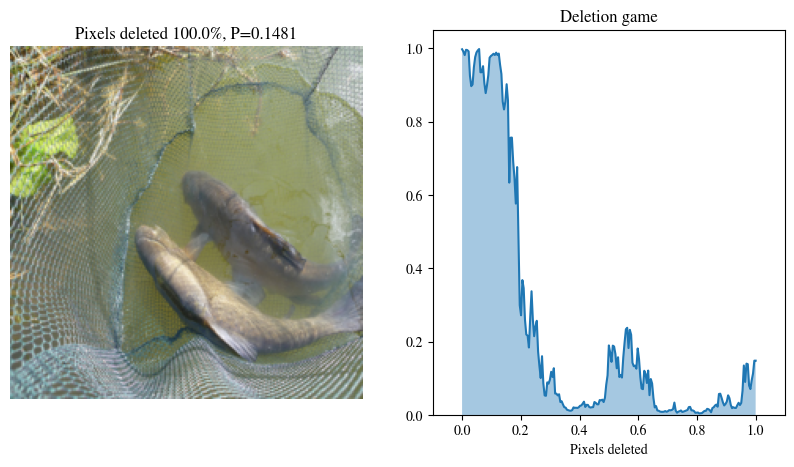

In [94]:
with torch.no_grad():
    del_eval_output_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
del_scores_archipelago = del_eval_output_archipelago['scores']
del_evaluator_bbm.plot(denormed_img[0], del_scores_archipelago[0])

 99%|█████████▉| 223/225 [00:01<00:00, 159.76it/s]


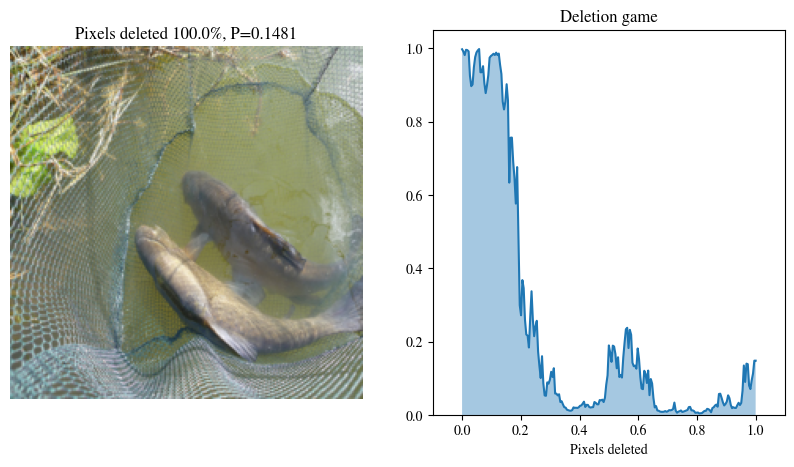

In [54]:
with torch.no_grad():
    del_eval_output_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
del_scores_archipelago = del_eval_output_archipelago['scores']
del_evaluator_bbm.plot(denormed_img[0], del_scores_archipelago[0])

In [90]:
gdel_evaluator_archipelago = GroupedDeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    gdel_score_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks)
print(gdel_score_archipelago)

tensor([0.1272], device='cuda:0')


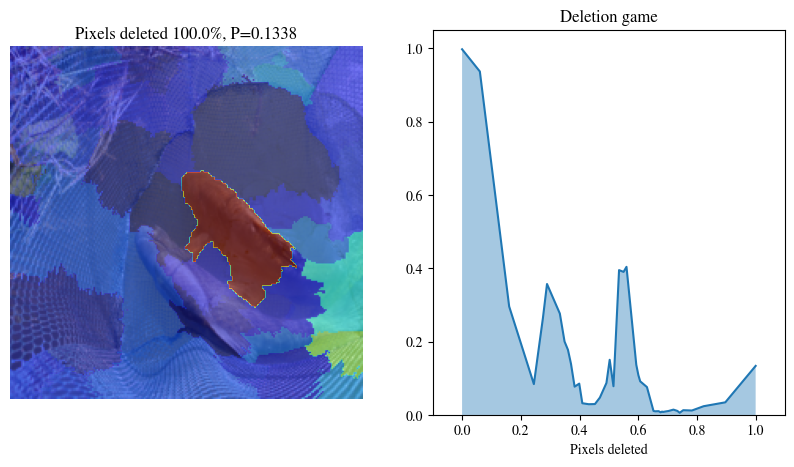

In [93]:
with torch.no_grad():
    gdel_eval_output_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gdel_evaluator_archipelago.plot(denormed_img[0], expln_scores_tensor, 
                                gdel_eval_output_archipelago['scores'][0], 
                                gdel_eval_output_archipelago['step_sizes'][0])

In [ ]:
with torch.no_grad():
    gdel_eval_output_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gdel_evaluator_archipelago.plot(denormed_img[0], expln_scores_tensor, 
                                gdel_eval_output_archipelago['scores'][0], 
                                gdel_eval_output_archipelago['step_sizes'][0])